<center> <img src = https://media.baamboozle.com/uploads/images/394336/1641713500_2692709.jpeg alt="drawing" style="width: 800px; height:400px;" </center>

# Проект: классификация

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn import (
    ensemble,
    linear_model,
    metrics,
    preprocessing,
    tree
    )
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder 

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [36]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

age         job  marital  education default       balance housing loan  \
0   59      admin.  married  secondary      no   2 343,00 $      yes   no   
1   56      admin.  married  secondary      no      45,00 $       no   no   
2   41  technician  married  secondary      no   1 270,00 $      yes   no   
3   55    services  married  secondary      no   2 476,00 $      yes   no   
4   54      admin.  married   tertiary      no     184,00 $       no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes  
3  unknown    5   may       579         1     -1         0  unknown     yes  
4  unknown    5   may       673         2     -1         0  unknown     yes

In [37]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [38]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
print(df.job.value_counts())
print(df.education.value_counts())

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64


### Задание 3

In [39]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].replace({r'\$': '', ',': '.', ' ':''}, regex=True)
df['balance'] = df['balance'].astype (float)

# Вычислим среднее значение по преобразованному в корректный вид признаку 'balance'. Ответ округлите до трёх знаков
# после точки-разделителя.
print(round(df['balance'].mean(), 3))

1529.129


### Задание 4

In [40]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance']. fillna(df['balance'].median())

# Вычислим среднее значение по преобразованному в корректный вид признаку 'balance'. Ответ округлим до трёх знаков
# после точки-разделителя.
print(round(df['balance'].mean(), 3))

1526.936


### Задание 5

In [41]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].replace({r'unknown': 'management'}, regex=True)
df['education'] = df['education'].replace({r'unknown': 'secondary'}, regex=True)

# Рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т.е. для тех,
# у кого одновременно самая популярная работа и самое популярное образование). Ответ округлим до трёх знаков после
# точки-разделителя.
df.loc[((df['job']=='management') & (df['education']=='secondary')), 'balance'].mean().round(3)

1598.883

### Задание 6

In [42]:
x = df['balance']
q1 = np.percentile(x, 25)  # 25-й перцентиль
q3 = np.percentile(x, 75)  # 75-й перцентиль
iqr = q3 - q1 # межквартильный размах
lower_bound = round(q1 - (iqr*1.5)) # нижняя граница выбросов
upper_bound = round(q3 + (iqr*1.5)) # верхняя граница выбросов
 
print('25-й перцентиль: {},'.format(q1),
      '75-й перцентиль: {},'.format(q3),
      "IQR: {}, ".format(iqr),
      "Границы выбросов: [{lb}, {ub}].".format(lb=lower_bound, ub=upper_bound))

# Анализ выбросов методом Тьюки (нестрогое неравенство)
df_nb = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]
df_nb.shape

25-й перцентиль: 123.0, 75-й перцентиль: 1699.0, IQR: 1576.0,  Границы выбросов: [-2241, 4063].


(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

In [43]:
df_nb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


no     5424
yes    4681
Name: deposit, dtype: int64

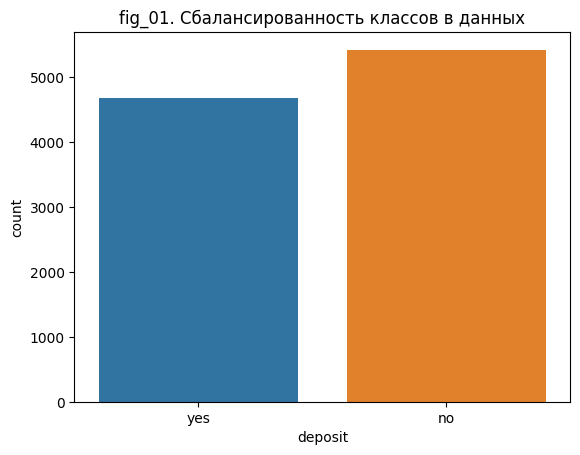

In [44]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
display(df_nb['deposit'].value_counts())
sns.countplot(
        data=df_nb,
        x="deposit"
        )
plt.title("fig_01. Сбалансированность классов в данных");


### Задания 2 и 3

age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  
max      854.000000     58.000000

<Figure size 640x480 with 0 Axes>

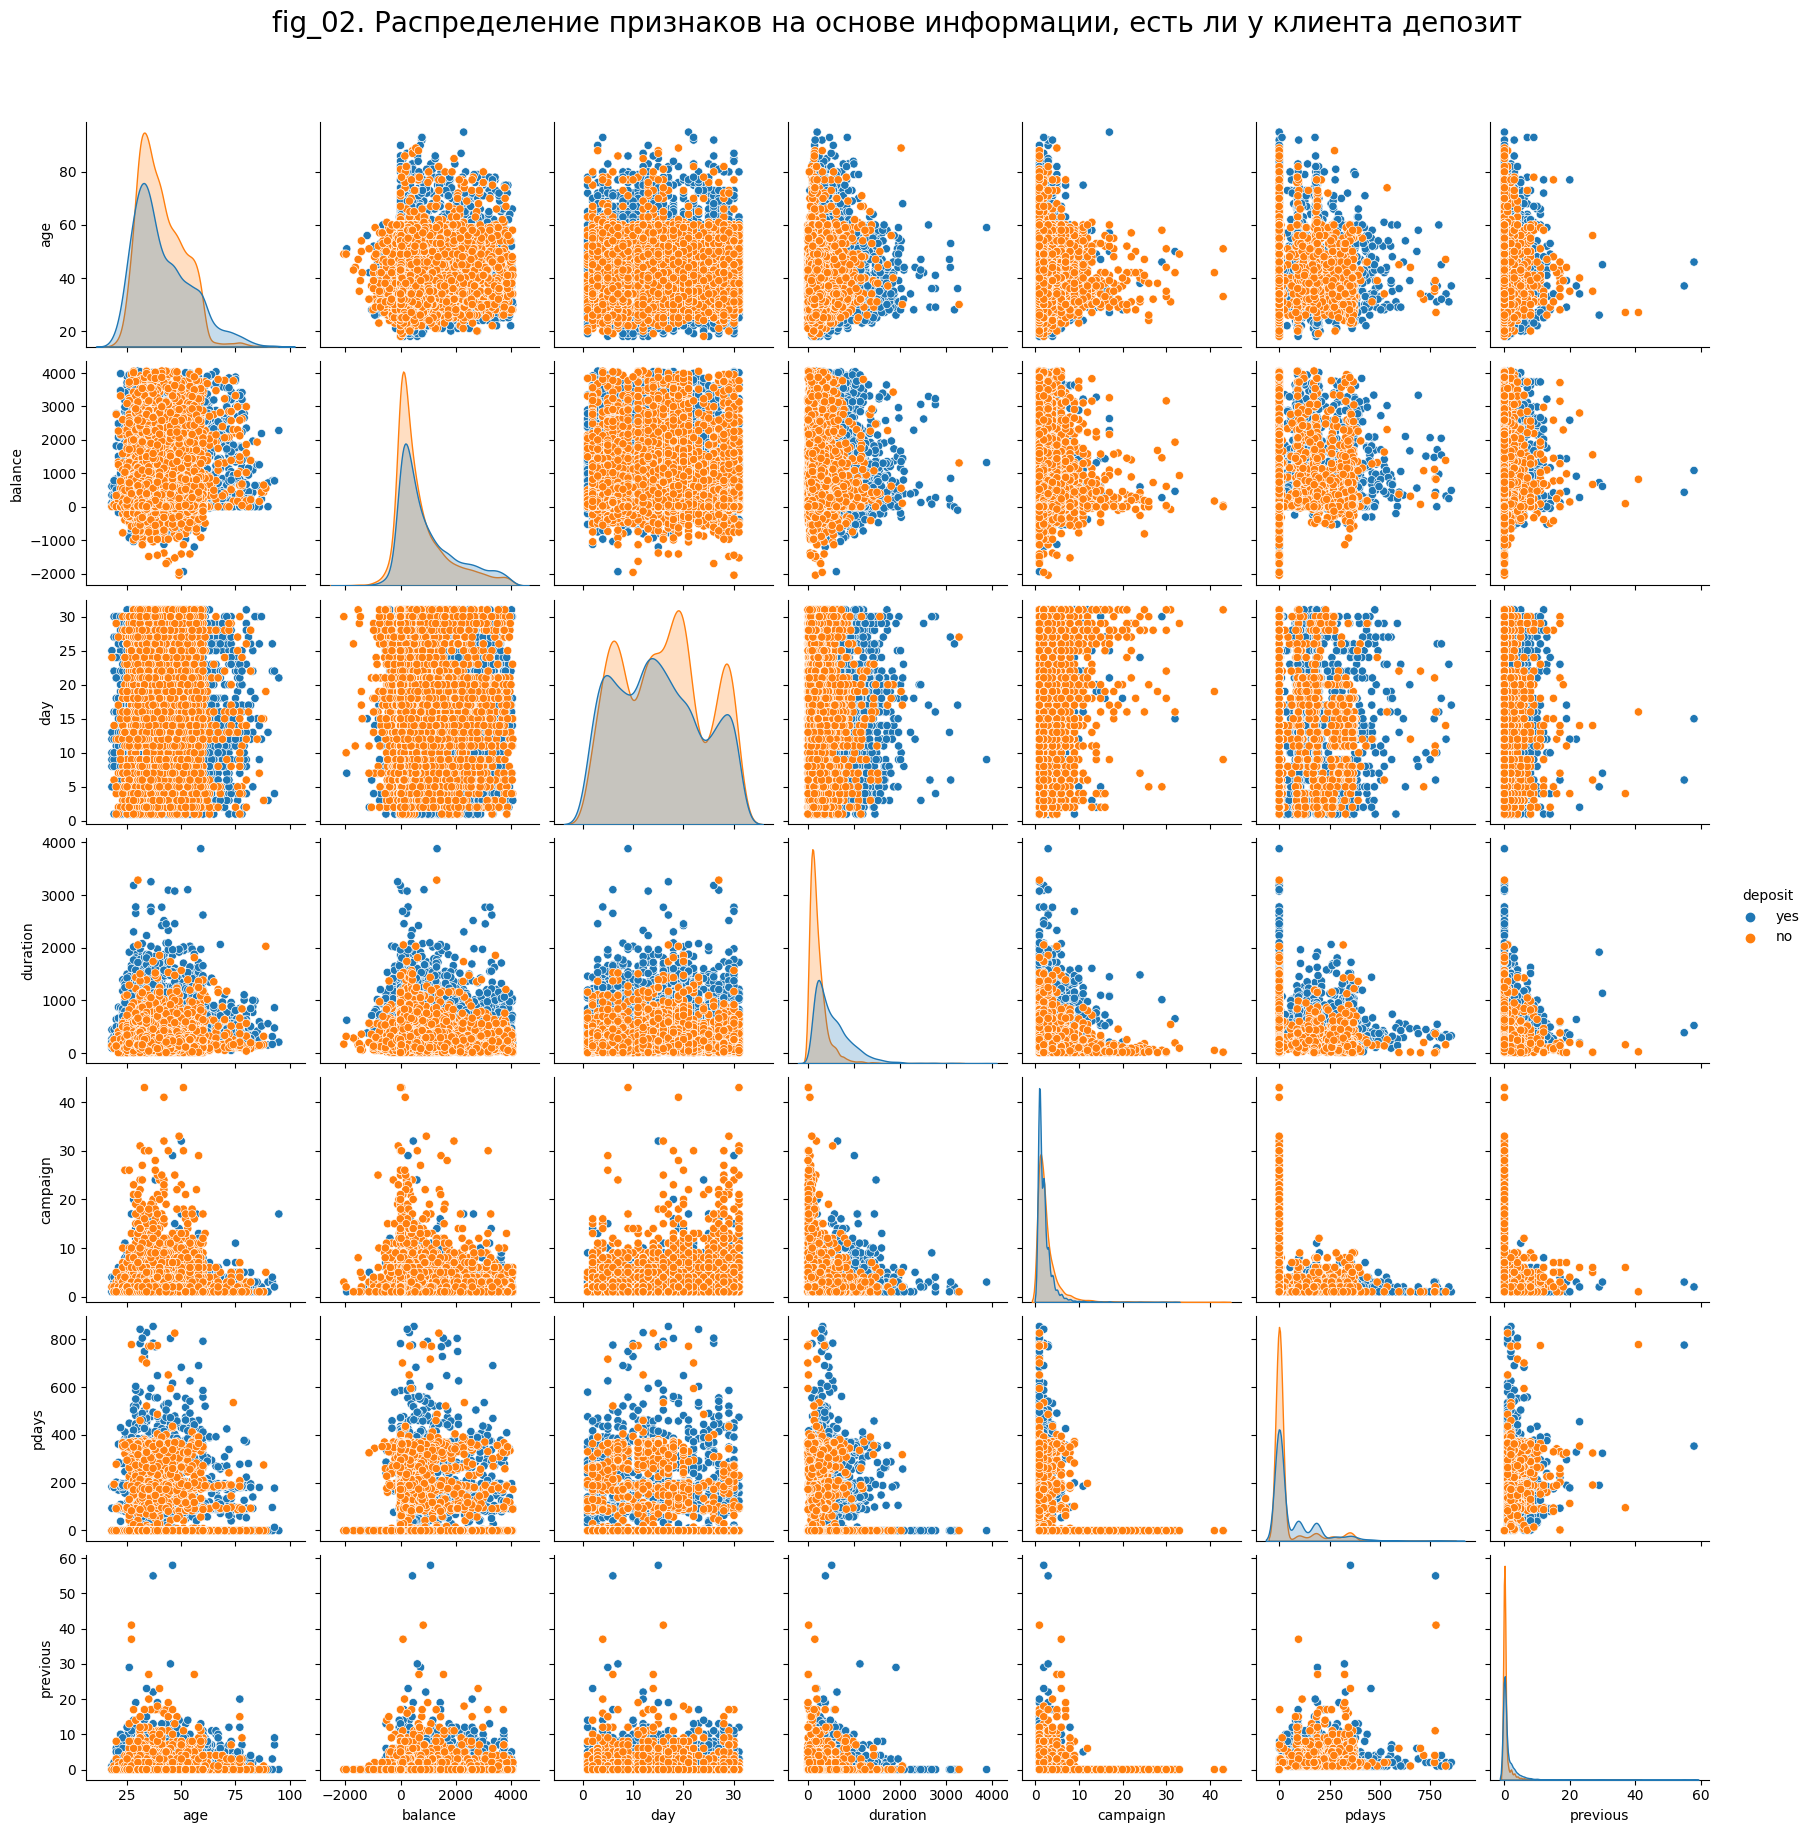

In [45]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
display(df_nb.describe())

to_plot = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'deposit']
plt.figure()
sns.pairplot(df_nb[to_plot], hue= 'deposit')
plt.suptitle(
    "fig_02. Распределение признаков на основе информации, есть ли у клиента депозит",
    y=1.05,
    fontsize=20
    )
plt.show();

In [46]:
fig_03 = px.histogram(
    data_frame= df_nb,
    x='age',
    color = "deposit",
    nbins=10,
    title='fig_03. Распределение возраста в зависимости от депозита',
    width=800,
    height=500,
    marginal='box',
    histnorm='percent'
)

if not os.path.exists("images"):
    os.mkdir("images")
fig_03.write_html("images/fig_03.png")
fig_03.show()

<center> <img src = https://github.com/Licharg/SkillFactory/blob/master/Projects/Project_4/images/fig_03.png?raw=true alt="drawing" style="width:800px;">

In [47]:
fig_04 = px.histogram(
    data_frame= df_nb,
    x='balance',
    color = "deposit",
    nbins=10,
    title='fig_04. Распределение баланса в зависимости от депозита',
    width=800,
    height=500,
    marginal='box',
    histnorm='percent'
)

if not os.path.exists("images"):
    os.mkdir("images")
fig_04.write_html("images/fig_04.png")
fig_04.show()

In [48]:
fig_05 = px.histogram(
    data_frame= df_nb,
    x='duration',
    color = "deposit",
    nbins=10,
    title='fig_05. Распределение продолжительности контакта в зависимости от депозита',
    width=800,
    height=500,
    marginal='box',
    histnorm='percent'
)

if not os.path.exists("images"):
    os.mkdir("images")
fig_05.write_html("images/fig_05.png")
fig_05.show()

In [49]:
fig_06 = px.histogram(
    data_frame= df_nb,
    x='pdays',
    color = "deposit",
    nbins=10,
    title='fig_06. Распределение количества пропущенных дней в зависимости от депозита',
    width=800,
    height=600,
    marginal='box',
    histnorm='percent'
)

if not os.path.exists("images"):
    os.mkdir("images")
fig_06.write_html("images/fig_06.png")
fig_06.show()

In [50]:
fig_07 = px.histogram(
    data_frame= df_nb,
    x='campaign',
    color = "deposit",
    nbins=10,
    title='fig_07. Распределение контактов в зависимости от депозита',
    width=800,
    height=500,
    marginal='box',
    histnorm='percent'
)

if not os.path.exists("images"):
    os.mkdir("images")
fig_07.write_html("images/fig_07.png")
fig_07.show()

In [51]:
fig_08 = px.histogram(
    data_frame= df_nb,
    x='previous',
    color = "deposit",
    nbins=10,
    title='fig_08. Распределение контактов в зависимости от депозита',
    width=800,
    height=500,
    marginal='box',
    histnorm='percent'
)

if not os.path.exists("images"):
    os.mkdir("images")
fig_08.write_html("images/fig_08.png")
fig_08.show()

На основании описательных статистик для количественных переменных, можно сделать следующие выводы:

- Призники: `'age'`, `'balance'` и `'day'` имеют распределение близкое к нормальному; признаки: `'duration'`, `'campaign'`, `'pdays'`, `'previous'` и `'deposit'` имеют распределение близкое к логнормальному.
- Признаки: `'pdays'` и `'previous'` все данные, в основном, сосредоточены в зоне около нулевых значений.
- Признак `'pdays'` имеет отрицательное минимальное значение, такого быть не должно, похоже на выброс.
- Признак `'day'` имеет наибольший разброс, но с точки зрения логики это возможно, т.к. контакт равновероятен в любой день месяца.
- Призники: `'balance'`, `'duration'` и `'pdays'` имеют аномальные значения аномальные значения с большей стороны (оссиметрия вправо).

### Задания 4 и 5

In [52]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df_nb.describe(include=['object'])
#постройте визуализации, иллюстрирующие результаты

job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome deposit  
count   10105    10105   10105  
unique     12        4       2  
top       may  unknown      no  
freq     2617     7570    5424

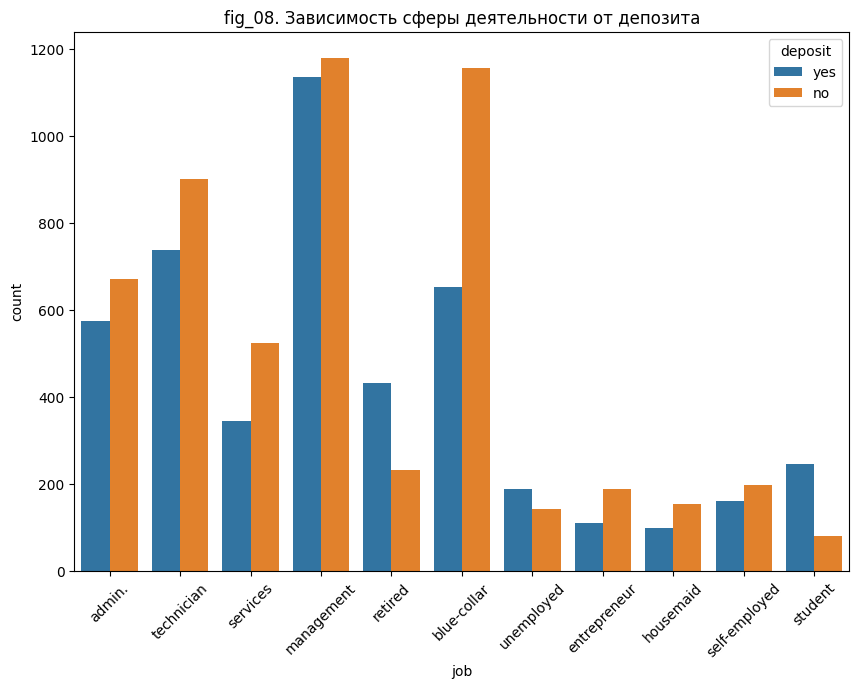

In [53]:
fig = plt.figure(figsize=(10, 7))
ax=sns.countplot(
        data=df_nb,
        x="job",
        hue='deposit'
        )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
plt.title("fig_08. Зависимость сферы деятельности от депозита");

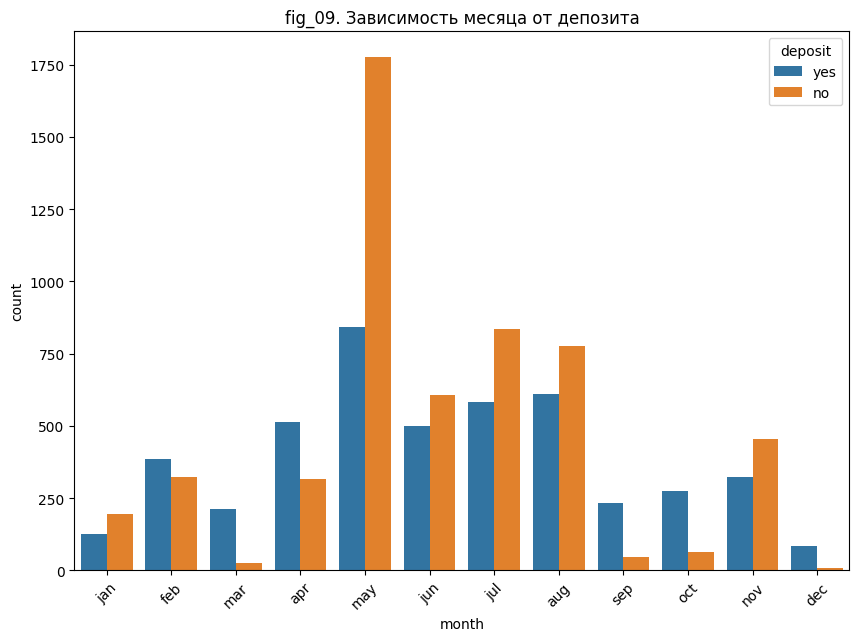

In [54]:
fig_09 = plt.figure(figsize=(10, 7))
month_order = ['jan','feb','mar','apr','may','jun','jul', 'aug', 'sep', 'oct', 'nov', 'dec']
sns.countplot(
        data=df_nb,
        x="month",
        order = month_order,
        hue='deposit'
        )
plt.xticks(rotation=45)
plt.title("fig_09. Зависимость месяца от депозита");

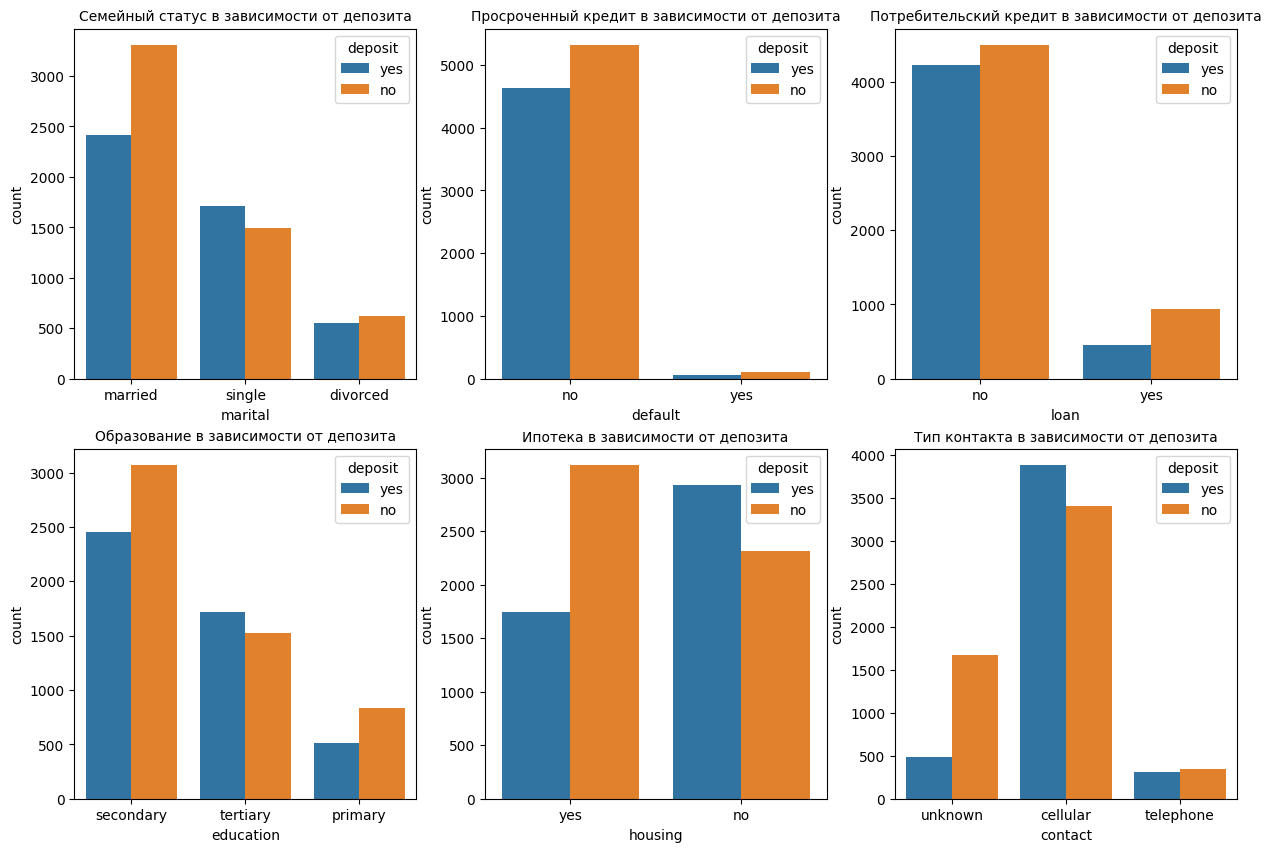

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

sns.countplot(
        data=df_nb,
        x="marital",
        hue='deposit',
        ax=axes[0,0]
        );
axes[0,0].set_title('Семейный статус в зависимости от депозита', fontsize=10)

sns.countplot(
        data=df_nb,
        x="education",
        hue='deposit',
        ax=axes[1,0]
        );
axes[1,0].set_title('Образование в зависимости от депозита', fontsize=10)

sns.countplot(
        data=df_nb,
        x="default",
        hue='deposit',
        ax=axes[0,1]
        );
axes[0,1].set_title('Просроченный кредит в зависимости от депозита', fontsize=10)

sns.countplot(
        data=df_nb,
        x="housing",
        hue='deposit',
        ax=axes[1,1]
        );
axes[1,1].set_title('Ипотека в зависимости от депозита', fontsize=10)

sns.countplot(
        data=df_nb,
        x="loan",
        hue='deposit',
        ax=axes[0,2]
        );
axes[0,2].set_title('Потребительский кредит в зависимости от депозита', fontsize=10)

sns.countplot(
        data=df_nb,
        x="contact",
        hue='deposit',
        ax=axes[1,2]
        );
axes[1,2].set_title('Тип контакта в зависимости от депозита', fontsize=10);

На основании описательных статистик для категориальных переменных, можно сделать следующие выводы.

Попробуйте извлечь максимум информации из тех показателей, которые можете получить.
- Всего представлено 11 сфер занятости среди клиентов банка, наиболее популярная - `'management'`.
- Маркетинговая кампания проходила каждый месяц, больше всего клинтов наблюдается в тёплое время года (с апреля до сентября), наиболее популярный месяц - `'may'`.
- Чаще всего встречается семейное положение `'married'`, более половины от всех клиентов.
- клиентами бразование? Постарайтесь дать достаточно подробную интерпретацию. Для лучшей наглядности добавьте визуализации по каждой категориальной переменной.

### Задание 6

deposit     no   yes
poutcome            
failure    562   547
other      216   265
success     84   861
unknown   4562  3008


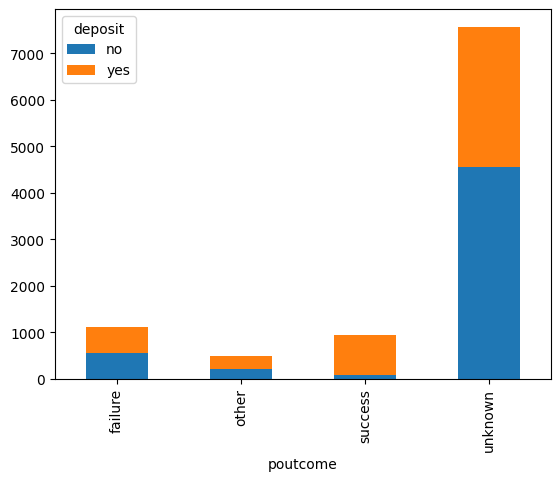

In [56]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
types = df_nb.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
print(types)
types.plot(kind='bar', stacked='True');

### Задание 7

In [57]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
types = df_nb.groupby("month")['deposit'].value_counts(normalize=False).unstack()
print(types)

deposit    no  yes
month             
apr       317  513
aug       775  610
dec         9   84
feb       323  386
jan       194  125
jul       836  582
jun       606  498
mar        24  213
may      1776  841
nov       456  324
oct        62  273
sep        46  232


In [58]:
mask_1 = df_nb.groupby([df_nb['deposit']=='no'])['month'].value_counts(normalize=False).unstack()
mask_2 = df_nb.groupby([df_nb['deposit']=='yes'])['month'].value_counts(normalize=False).unstack()
ratio = (mask_1) / (mask_1 + mask_2)
print(round(ratio*100))

month     apr   aug   dec   feb   jan   jul   jun   mar   may   nov   oct  \
deposit                                                                     
False    62.0  44.0  90.0  54.0  39.0  41.0  45.0  90.0  32.0  42.0  81.0   
True     38.0  56.0  10.0  46.0  61.0  59.0  55.0  10.0  68.0  58.0  19.0   

month     sep  
deposit        
False    83.0  
True     17.0  


In [59]:
# Эталонное решение № 1
#res_n = df[df.deposit == 'no'].groupby(['month'])['deposit'].count()
#res_k = df.groupby(['month'])['deposit'].count()
#res_n/res_k

In [60]:
# Эталонное решение № 2
for i in np.unique(df_nb.month):
    print(i, df_nb[(df_nb.month == i)&(df_nb.deposit == 'no')].shape[0]/df_nb[(df_nb.month == i)].shape[0])

apr 0.3819277108433735
aug 0.5595667870036101
dec 0.0967741935483871
feb 0.45557122708039494
jan 0.6081504702194357
jul 0.5895627644569816
jun 0.5489130434782609
mar 0.10126582278481013
may 0.6786396637371036
nov 0.5846153846153846
oct 0.18507462686567164
sep 0.16546762589928057


### Задание 8

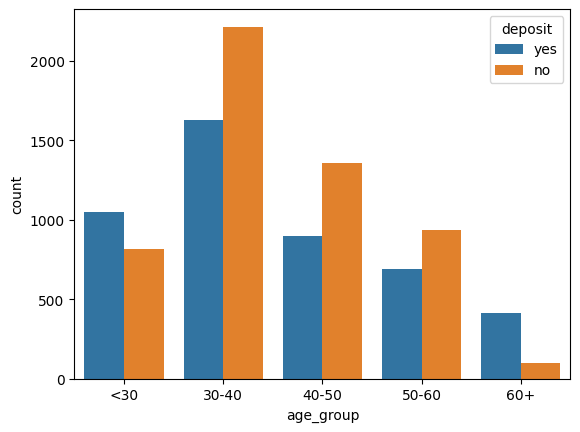

In [61]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит,
# чем отказываться от предложения
df_nb['age_group'] = pd.cut(df_nb.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df_nb);

Из анализа графика можно сделать следующие выводы:
- Большинство клиентов банка от 18 до 50 лет.
- Клиенты в возрасте до 30 лет и свыше 60 лет, чаще соглашаются на депозит.
- Клиенты банка в возрасте от 30 до 60 лет, чаще отказываются от депозита.

### Задания 9 и 10

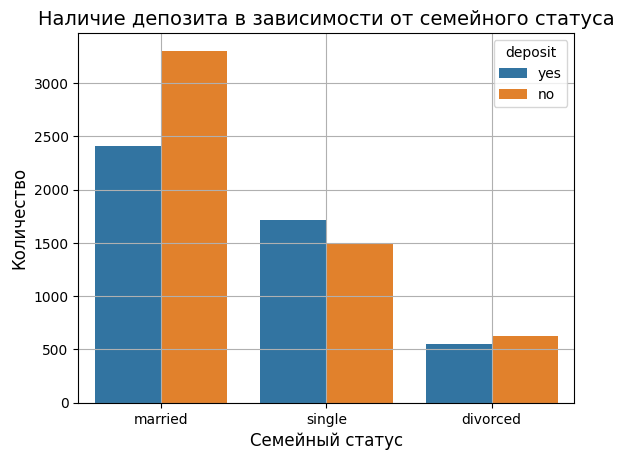

In [62]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig, axes = plt.subplots()
sns.countplot(
    data=df_nb,
    x='marital',
    hue='deposit'
)
plt.title('Наличие депозита в зависимости от семейного статуса', fontsize=14);
plt.xlabel('Семейный статус', fontsize=12);
plt.ylabel('Количество', fontsize=12);
plt.grid();

Из анализа графика можно сделать следующие выводы:
- Большинство клиентов банка имеют семейный статус - женаты.
- Одинокие клиенты, чаще соглашаются на депозит.
- Женатые и разведённые клиенты, чаще отказываются от депозита.

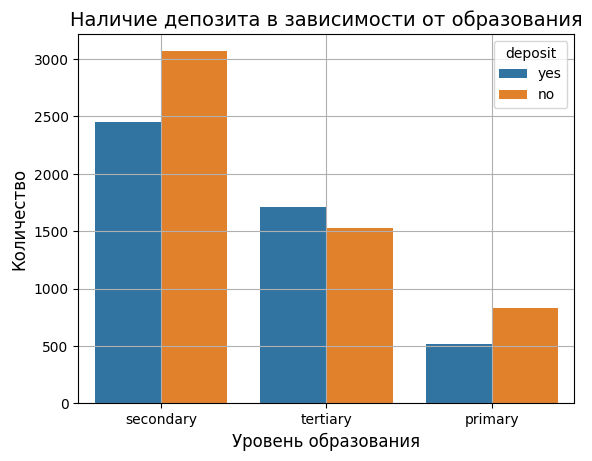

In [63]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig, axes = plt.subplots()
sns.countplot(
    data=df_nb,
    x='education',
    hue='deposit'
)
plt.title('Наличие депозита в зависимости от образования', fontsize=14);
plt.xlabel('Уровень образования', fontsize=12);
plt.ylabel('Количество', fontsize=12);
plt.grid();

Из анализа графика можно сделать следующие выводы:
- Большинство клиентов банка имеют среднее образование.
- Клиенты с высшим образованием, чаще соглашаются на депозит.
- Клиенты с начальным и средним образованием, чаще отказываются от депозита.

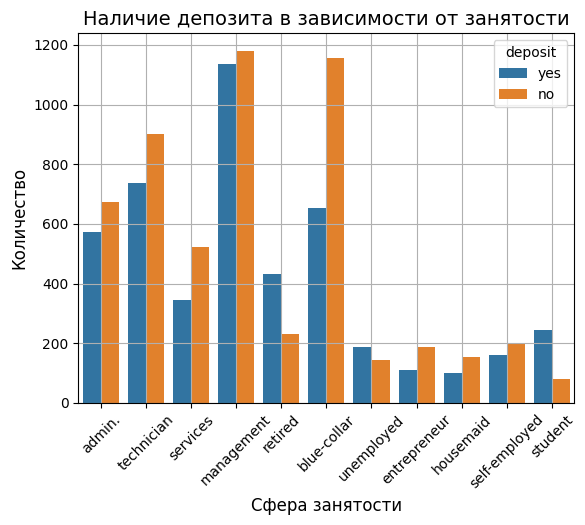

In [64]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig, axes = plt.subplots()
sns.countplot(
    data=df_nb,
    x='job',
    hue='deposit'
)
plt.title('Наличие депозита в зависимости от занятости', fontsize=14);
plt.xlabel('Сфера занятости', fontsize=12);
plt.ylabel('Количество', fontsize=12);
plt.xticks(rotation=45);
plt.grid();

Из анализа графика можно сделать следующие выводы:
- Большинство клиентов банка работаютв сфере: менеджмента, технологии и рабочего класса.
- Студенты, безработные и пенсионеры чаще соглашаются на депозит.
- Клиенты в остальных сферах занятости, чаще отказываются от депозита.

### Задание 11

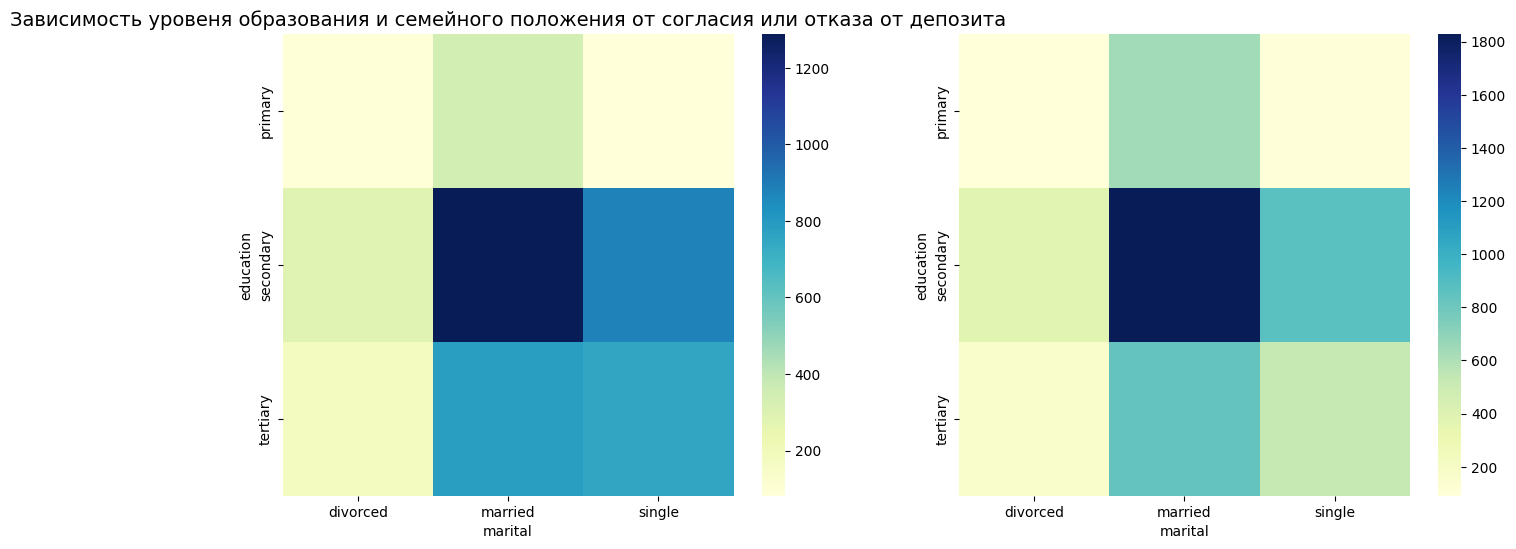

In [65]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_no = df_nb[df_nb['deposit']=='no']
df_yes = df_nb[df_nb['deposit']=='yes']

pivot_no=df_no.pivot_table(
values='deposit',
index='education',
columns='marital',
aggfunc='count'
)

pivot_yes=df_yes.pivot_table(
values='deposit',
index='education',
columns='marital',
aggfunc='count'
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

heatmap_yes = sns.heatmap(
    data=pivot_yes,
    cmap='YlGnBu',
    ax = axes[0]
    )
heatmap_yes.set_title('Зависимость уровеня образования и семейного положения от согласия или отказа от депозита',
                      fontsize=14);

heatmap_no = sns.heatmap(
    data=pivot_no,
    cmap='YlGnBu',
    ax = axes[1]
    );


## Часть 3: преобразование данных

### Задание 1

In [66]:
# преобразуйте уровни образования
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df_nb['education'] = lab_enc.fit_transform(df_nb['education'])
df_nb['education'].sum()

11995

### Задания 2 и 3

In [67]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Кодирование признака
df_nb['age_group'] = lab_enc.fit_transform(df_nb['age_group'])

In [68]:
df_nb["deposit"] = df_nb["deposit"].replace("yes", 1).replace("no", 0)
df_nb["default"] = df_nb["default"].replace("yes", 1).replace("no", 0)
df_nb["housing"] = df_nb["housing"].replace("yes", 1).replace("no", 0)
df_nb["loan"] = df_nb["loan"].replace("yes", 1).replace("no", 0)

In [69]:
deposit_std = round(df_nb["deposit"].std(),3)
default_mean = df_nb["default"].mean()
housing_mean = df_nb["housing"].mean()
loan_mean = df_nb["loan"].mean()
sum_mean = round((default_mean + housing_mean + loan_mean),3)
print(f'Стандартное отклонение deposit составляет: {deposit_std}')
print(f'Сумма средних арифметических составляет: {sum_mean}')

Стандартное отклонение deposit составляет: 0.499
Сумма средних арифметических составляет: 0.635


### Задание 4

In [70]:
df_nb

age          job  marital  education  default  balance  housing  loan  \
0       59       admin.  married          1        0   2343.0        1     0   
1       56       admin.  married          1        0     45.0        0     0   
2       41   technician  married          1        0   1270.0        1     0   
3       55     services  married          1        0   2476.0        1     0   
4       54       admin.  married          2        0    184.0        0     0   
...    ...          ...      ...        ...      ...      ...      ...   ...   
11157   33  blue-collar   single          0        0      1.0        1     0   
11158   39     services  married          1        0    733.0        0     0   
11159   32   technician   single          1        0     29.0        0     0   
11160   43   technician  married          1        0      0.0        0     1   
11161   34   technician  married          1        0      0.0        0     0   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0       unknown    5   may      1042         1     -1         0  unknown   
1       unknown    5   may      1467         1     -1         0  unknown   
2       unknown    5   may      1389         1     -1         0  unknown   
3       unknown    5   may       579         1     -1         0  unknown   
4       unknown    5   may       673         2     -1         0  unknown   
...         ...  ...   ...       ...       ...    ...       ...      ...   
11157  cellular   20   apr       257         1     -1         0  unknown   
11158   unknown   16   jun        83         4     -1         0  unknown   
11159  cellular   19   aug       156         2     -1         0  unknown   
11160  cellular    8   may         9         2    172         5  failure   
11161  cellular    9   jul       628         1     -1         0  unknown   

       deposit  age_group  
0            1          2  
1            1          2  
2            1          1  
3            1          2  
4            1          2  
...        ...        ...  
11157        0          0  
11158        0          0  
11159        0          0  
11160        0          1  
11161        0          0  

[10105 rows x 18 columns]

In [71]:
# создайте дамми-переменные
df_dum = pd.get_dummies(df_nb, columns = ['job', 'marital', 'contact', 'month', 'poutcome'])

In [72]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

Наиболее высокая корреляция между признаками:


level_0            level_1         0
1361   contact_unknown   contact_cellular  0.837885
459              pdays   poutcome_unknown  0.824031
1176   marital_married     marital_single  0.779038
505           previous   poutcome_unknown  0.628346
1941  poutcome_failure              pdays  0.608719
2112  poutcome_unknown   poutcome_failure  0.606736
2069  poutcome_success   poutcome_unknown  0.555044
18                 age        job_retired  0.545524
63           education     job_management  0.518735
424              pdays           previous  0.513708
1196    marital_single                age  0.464737
333           duration            deposit  0.457818
222            housing          month_may  0.432605
1270  contact_cellular  contact_telephone  0.425010
1372   contact_unknown          month_may  0.415598
1129  marital_divorced    marital_married  0.414273
1370   contact_unknown          month_jun  0.388312
2023    poutcome_other   poutcome_unknown  0.386326
645    job_blue-collar          education  0.371796
502           previous   poutcome_failure  0.347800

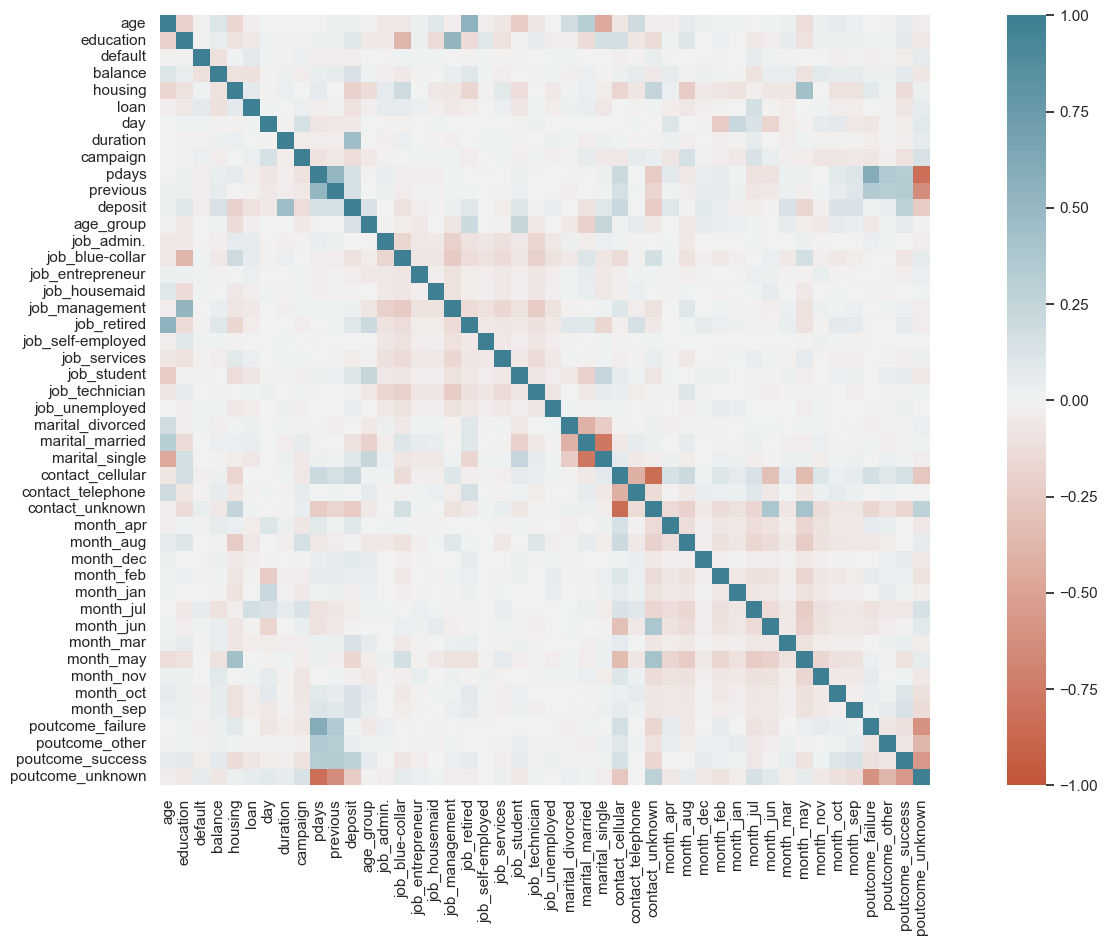

In [73]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
# Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
corr = df_dum.corr()
sns.set(rc={'figure.figsize':(20, 10)})
ax = sns.heatmap(
    corr, 
    vmin=-1, 
    vmax=1, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
);
print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending=False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
corr_unstack.iloc[:20, :]

### Задания 7 и 8

In [74]:
X = df_dum.drop(['deposit'], axis=1)
y = df_dum['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [75]:
# рассчитайте необходимые показатели
print(X_train.shape, X_test.shape)
print(round(y_test.mean(),2))

(6770, 45) (3335, 45)
0.46


### Задание 9

In [76]:
from sklearn.feature_selection import SelectKBest, f_classif

# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [77]:
df = df_dum[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_group', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [78]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           
X_train_scaled = scaler.transform(X_train)    
X_test_scaled = scaler.transform(X_test)      

print(round(X_test_scaled[:, 0].mean(),2))  

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [79]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)

# Выводим значения метрики 
print("accuracy на тренировочном наборе: {:.2f}".format(log_reg.score(X_train_scaled, y_train)))
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))

accuracy на тренировочном наборе: 0.82
accuracy на тестовом наборе: 0.81


### Задания 2,3,4

In [80]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

dt.fit(X_train_scaled, y_train)

# Выводим значения метрики 
print("accuracy на тренировочном наборе: {:.2f}".format(dt.score(X_train_scaled, y_train)))
print("accuracy на тестовом наборе: {:.2f}".format(dt.score(X_test_scaled, y_test)))

accuracy на тренировочном наборе: 1.00
accuracy на тестовом наборе: 0.75


In [81]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 5
)

dt.fit(X_train_scaled, y_train)

# Выводим значения метрики 
print("accuracy_5 на тренировочном наборе: {:.2f}".format(dt.score(X_train_scaled, y_train)))
print("accuracy_5 на тестовом наборе: {:.2f}".format(dt.score(X_test_scaled, y_test)))

accuracy_5 на тренировочном наборе: 0.80
accuracy_5 на тестовом наборе: 0.79


In [82]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)

# Выводим значения метрики 
print("accuracy_6 на обучающем наборе: {:.2f}".format(dt.score(X_train_scaled, y_train)))
print("accuracy_6 на тестовом наборе: {:.2f}".format(dt.score(X_test_scaled, y_test)))

accuracy_6 на обучающем наборе: 0.82
accuracy_6 на тестовом наборе: 0.81


In [83]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 7
)

dt.fit(X_train_scaled, y_train)

# Выводим значения метрики 
print("accuracy_7 на обучающем наборе: {:.2f}".format(dt.score(X_train_scaled, y_train)))
print("accuracy_7 на тестовом наборе: {:.2f}".format(dt.score(X_test_scaled, y_test)))

accuracy_7 на обучающем наборе: 0.84
accuracy_7 на тестовом наборе: 0.81


### Задание 5

In [84]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2,5,7,10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3,
                        scoring=('f1'), 
                        return_train_score=True
                        )

model_cv.fit(X_train_scaled, y_train)

print('Best hyperparameters are: '+str(model_cv.best_params_))
print('Best score is: '+str(model_cv.best_score_))

Best hyperparameters are: {'max_depth': 7, 'min_samples_split': 7}
Best score is: 0.7958644308011316


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [85]:
from sklearn.metrics import classification_report
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred = rf.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [86]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))

# Правильный ответ, Recall: 0.84

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [87]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred_stack = stack.predict(X_test_scaled)
#Выводим отчет о метриках
print(classification_report(y_test, y_pred_stack))

# Правильный ответ, precision: 0.82

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [88]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

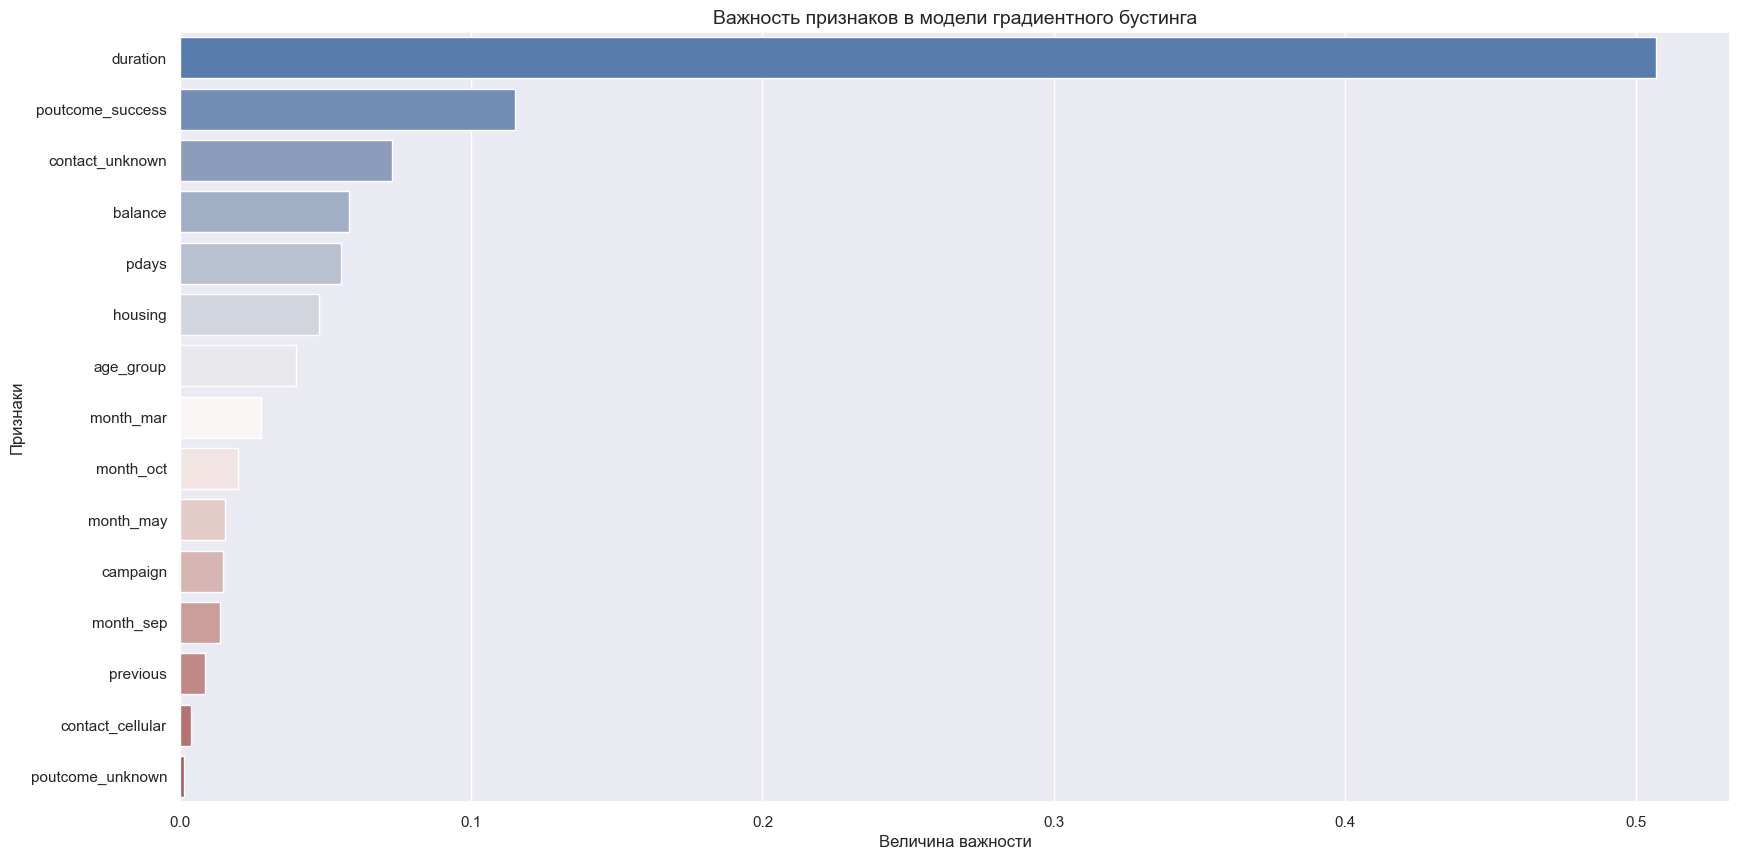

In [93]:
gb_feat = pd.Series(stack.named_estimators_['gb'].feature_importances_,
                    index=X_train.columns).sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую важность признаков в модели
barplot = sns.barplot(
    data = gb_feat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);

barplot.set_title('Важность признаков в модели градиентного бустинга', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

### Задания 6,7,8

In [94]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# Устанавливаем библиотеку
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [95]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.5.0


In [96]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))

  return score

In [97]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-02-12 16:23:09,946] A new study created in memory with name: RandomForestClassifier
[I 2024-02-12 16:23:10,781] Trial 0 finished with value: 0.8130752142177086 and parameters: {'n_estimators': 164, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8130752142177086.
[I 2024-02-12 16:23:11,788] Trial 1 finished with value: 0.8099173553719009 and parameters: {'n_estimators': 191, 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8130752142177086.
[I 2024-02-12 16:23:13,351] Trial 2 finished with value: 0.8183821214982688 and parameters: {'n_estimators': 165, 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8183821214982688.
[I 2024-02-12 16:23:14,244] Trial 3 finished with value: 0.8175505050505052 and parameters: {'n_estimators': 115, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8183821214982688.
[I 2024-02-12 16:23:14,876] Trial 4 finished with value: 0.81760607979734 and parameters: {'n_e

CPU times: total: 16.3 s
Wall time: 16.3 s


In [98]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 131, 'max_depth': 19, 'min_samples_leaf': 6}
f1_score на обучающем наборе: 0.82


In [99]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
